# Tutorial 6.1: Static string

In this tutorial we will learn how to define the static equilibrium position of a string. Here, we will use the FEM to solve a geometrically nonlinear structure subject to gravity loading in a static configuration. The equation of motion of an axially deformed string can be obtained by coupling a string and a rod EOMs, giving the following system of PDEs:

$$ m\ddot{u} -EAu'' = q $$

$$ m \ddot{v} -T v'' = p $$

As usual, we first define the parameters:

In [1]:
pip install scipy;

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.1/38.1 MB 30.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 54.1 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install ipympl;

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.3/510.3 kB 10.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 13.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 34.3 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.8/960.8 kB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 48.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import matplotlib.pyplot as plt

L = 60      # [m] string length
D = 0.75*L  # [m] distance between supports
EA = 1e6    # [Pa] stiffness
m = 1       # [kg] mass
g = 9.81    # [m/s^2] gravity constant

We now define a parameter that will be used as a flag to determine if the string can handle tension only or if it can also handle compression. By default we set it to 1 (tension only). If you want to add the possibility to handle compressions, set it to 0.

In [4]:
TENSION_ONLY = 1

## Step 1: discretize the domain

We will use the FEM to solve this problem. Then, we start by discretizing the domain in such a way that the maximum element length $l_{max}$ is 1 m.

In [5]:
lmax = 1                    # [m] maximum length of each string(wire) element
nElem = int(np.ceil(L/lmax))# [-] number of elements   
lElem = L/nElem             # [m] actual tensionless element size
nNode = nElem + 1           # [-] number of nodes 

We create the nodal coordinates vector and an array with the properties of the element: node connectivity and material properties.

In [6]:
NodeCoord = np.zeros((nNode, 2))
Element = np.zeros((nElem, 5))

for iElem in np.arange(0, nElem):
    NodeLeft = iElem
    NodeRight = iElem + 1
    NodeCoord[NodeRight] = NodeCoord[NodeLeft] + [lElem, 0]
    Element[iElem, :] = [NodeLeft, NodeRight, m, EA, lElem]

Let's plot the undeformed (horizontal) position of the string, together with the position of the supports

(-3.0, 63.0, -0.05500000000000001, 0.05500000000000001)

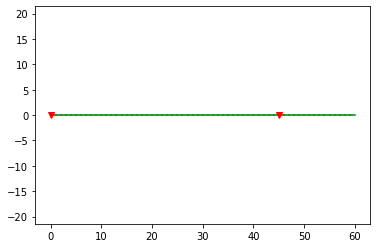

In [8]:
# plot the undeformed wire
plt.figure()
for iElem in np.arange(0, nElem):
    NodeLeft = int(Element[iElem, 0])
    NodeRight = int(Element[iElem, 1])

    plt.plot([NodeCoord[NodeLeft][0], NodeCoord[NodeRight][0]], [NodeCoord[NodeLeft][1], NodeCoord[NodeRight][1]], 'g')
    
# plot the supports
plt.plot([0, D], [0, 0], 'vr')
plt.axis('equal')

Note that the distance between supports is smaller than the string length. Therefore, the final string position will take a catenary shape between these two points.

## Step 2: Newton-Raphson:

#### Step 2.1: Guess the initial deformation

We know that the problem is nonlinear, so we will use the Newton-Raphson method to find the equilibrium position. In order to find this solution, we will need an initial guess. It can be any shape that satisfies the boundary conditions, the solver will take less iterations (less time) if we find an initial guess close to the final shape.

We start by defining the free and fixed DOFs.

In [10]:
nDof = 2*nNode                          # number of DOFs
FreeDof = np.arange(0, nDof)            # free DOFs 
FixedDof = [0,1, -2, -1]                # fixed DOFs
FreeDof = np.delete(FreeDof, FixedDof)  # remove the fixed DOFs from the free DOFs array

# free & fixed array indices
fx = FreeDof[:, np.newaxis]
fy = FreeDof[np.newaxis, :]

For the initial configuration, let us assume a parabola of the type:

$$ x(s) = D(s/L) $$

$$ y(s) = -4 SAG ((x/D) - (x/D)^2) $$

Where $s$ is the coordinate along the undeformed position of the wire and $SAG$ the maximum vertical distance of the string.

In [11]:
SAG = 20                            # Let us assume a big sag - this will assure that all elements
                                    # are under tension, which may be necesary for the convergence
                                    # of the solver
s = np.array([i[0] for i in NodeCoord])
x = D*(s/L)
y = -4*SAG*((x/D)-(x/D)**2)
u = np.zeros((nDof))
u[0:nDof+1:2] = x - np.array([i[0] for i in NodeCoord])
u[1:nDof+1:2] = y - np.array([i[1] for i in NodeCoord])
# The displacement of the node corresponds to the actual position minus the initial position
# Remember that we use a Global Coordinate System (GCS) here.

Plot the initial guess.

(-3.0, 63.0, -21.0, 1.0)

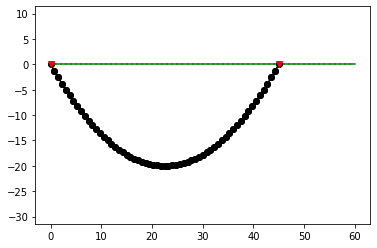

In [12]:
# plot the initial guess
plt.figure()
for iElem in np.arange(0, nElem):
    NodeLeft = int(Element[iElem, 0])
    NodeRight = int(Element[iElem, 1])
    DofsLeft = 2*NodeLeft 
    DofsRight = 2*NodeRight
    plt.plot([NodeCoord[NodeLeft][0] + u[DofsLeft], NodeCoord[NodeRight][0] + u[DofsRight]], 
                [NodeCoord[NodeLeft][1] + u[DofsLeft + 1], NodeCoord[NodeRight][1] + u[DofsRight + 1]], '-ok')
    plt.plot([NodeCoord[NodeLeft][0], NodeCoord[NodeRight][0]], [NodeCoord[NodeLeft][1], NodeCoord[NodeRight][1]], 'g')
    
# plot the supports
plt.plot([0, D], [0, 0], 'vr')
plt.axis('equal')

#### Step 2.2: iteration until convergence

We want to solve a nonlinear system with the following residual:

$$ \bf{R}(\bf{u}) = \bf{F}_{ext} -\bf{K}(\bf{u})\bf{u} $$

In the external force $ \bf{F}_{ext} $ we will only have the contribution of the gravity load, which does not depend on the position of the string. Then, we can take it out of the iteration loop and assemble it at the beginning.

In [13]:
Pext = np.zeros((nDof))
for iElem in np.arange(0, nElem):
    NodeLeft = int(Element[iElem, 0])
    NodeRight = int(Element[iElem, 1])
    DofsLeft = 2*NodeLeft 
    DofsRight = 2*NodeRight
    l0 = Element[iElem, 4]
    m = Element[iElem, 2]
    Pelem = -g*l0*m/2           # Half weight to each node
    Pext[DofsLeft + 1] += Pelem
    Pext[DofsRight + 1] += Pelem

Next, we iterate until the residual is smaller than a certain tolerance. In this case, we enforce the relative residual with respect to the external load to be smaller than $\epsilon = 1e-3$:

$$ \text{CONV} = \frac{||\bf{R}(\bf{u}^i)||_2}{||\bf{F}_{ext}||_2} \leq \epsilon $$

We also enforce that the maximum number of iteration is 100 (to avoid infite loop if something goes wrong). At each iteration $i$ we perform the following steps:

1. Compute and assemble the elemental matrix $\bf{K} (\bf{u}^i)$ and elemental vector $\bf{F} (\bf{u}^i)$
2. Copmute the residual $\bf{R} (\bf{u}^i)$
3. Check convergence
4. If not converged, compute increment $ \bf{\delta u}^i =\bf{K} (\bf{u}^i)^{-1} \bf{R} (\bf{u}^i)$. Here, we also enforce that the increment must not be greater than the element length (for convergence purposes).
5. Update displacements $\bf{u}^{i+1} = {u}^i +\bf{\delta u}^i $

Iteration: 1 ...































Iteration: 2 ...





























Iteration: 3 ...

























Iteration: 4 ...



















Iteration: 5 ...










Iteration: 6 ...






Iteration: 7 ...



Iteration: 8 ...

Iteration: 9 ...

Iteration: 10 ...

Iteration: 11 ...

Iteration: 12 ...

Iteration: 13 ...

Iteration: 14 ...

Iteration: 15 ...

Iteration: 16 ...

Iteration: 17 ...

Iteration: 18 ...

Iteration: 19 ...

Iteration: 20 ...

Iteration: 21 ...

Iteration: 22 ...

Iteration: 23 ...

Iteration: 24 ...

Iteration: 25 ...

Iteration: 26 ...

Iteration: 27 ...

Iteration: 28 ...

Iteration: 29 ...

Iteration: 30 ...

Iteration: 31 ...

Iteration: 32 ...

Iteration: 33 ...

Converged solution at iteration: 33


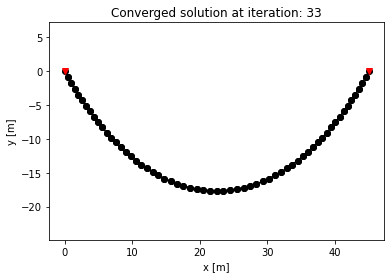

In [14]:
from StringForcesAndStiffness import StringForcesAndStiffness
# Convergence parameters
CONV = 0
PLOT = False
kIter = 0
nMaxIter = 100
TENSION = np.zeros((nElem))

while CONV == 0:
    kIter += 1
    print("Iteration: "+str(kIter)+" ...\n")
    # Check stability - define a number of maximum iterations. If solution
    # hasn't converged, check what is going wrong (if something).
    if kIter > nMaxIter:
        break
    
    # Assemble vector with internal forces and stiffnes matrix
    K = np.zeros((nDof*nDof)) 
    Fi = np.zeros((nDof))
    for iElem in np.arange(0, nElem):
        NodeLeft = int(Element[iElem, 0])
        NodeRight = int(Element[iElem, 1])
        DofsLeft = 2*NodeLeft 
        DofsRight = 2*NodeRight
        l0 = Element[iElem, 4]
        EA = Element[iElem, 3]
        NodePos = ([NodeCoord[NodeLeft][0] + u[DofsLeft], NodeCoord[NodeRight][0] + u[DofsRight]], 
                    [NodeCoord[NodeLeft][1] + u[DofsLeft + 1], NodeCoord[NodeRight][1] + u[DofsRight + 1]])
        Fi_elem, K_elem, Tension, WARN = StringForcesAndStiffness(NodePos, EA, l0, TENSION_ONLY)
        TENSION[iElem] = Tension


        if WARN:
            print("WARNING: Element "+str(iElem+1)+" is under compression.\n")
        
        Fi[DofsLeft:DofsLeft + 2] += Fi_elem[0]
        Fi[DofsRight:DofsRight + 2] += Fi_elem[1]

        # Assemble the matrices at the correct place
        # Get the degrees of freedom that correspond to each node
        Dofs_Left = 2*(NodeLeft) + np.arange(0, 2)
        Dofs_Right = 2*(NodeRight) + np.arange(0, 2)
        nodes = np.append(Dofs_Left , Dofs_Right)
        for i in np.arange(0, 4):
            for j in np.arange(0, 4):
                ij = nodes[i] + nodes[j]*nDof
                K[ij] = K[ij] + K_elem[i, j]

    K = K.reshape((nDof, nDof))

    # Calculate residual forces
    R = Pext - Fi

    # Check for convergence
    if np.linalg.norm(R[FreeDof])/np.linalg.norm(Pext[FreeDof]) < 1e-3:
        CONV = 1

    # Calculate increment of displacements
    du = np.zeros((nDof))
    du[FreeDof] = np.linalg.solve(K[fx, fy], R[FreeDof])

    # Apply archlength to help with convergence
    Scale = np.min(np.append(np.array([1]), lElem/np.max(np.abs(du))))
    du = du*Scale   # Enforce that each node does not displace
                    # more (at each iteration) than the length
                    # of the elements

    # Update displacement of nodes
    u += du

    # plot the updated configuration
    if PLOT:
        for iElem in np.arange(0, nElem):
            NodeLeft = int(Element[iElem, 0])
            NodeRight = int(Element[iElem, 1])
            DofsLeft = 2*NodeLeft 
            DofsRight = 2*NodeRight
            plt.plot([NodeCoord[NodeLeft][0] + u[DofsLeft], NodeCoord[NodeRight][0] + u[DofsRight]], 
                        [NodeCoord[NodeLeft][1] + u[DofsLeft + 1], NodeCoord[NodeRight][1] + u[DofsRight + 1]], '-ok')
            
        # plot the supports
        plt.plot([0, D], [0, 0], 'vr')
        plt.axis('equal')
        plt.xlabel("x [m]")
        plt.ylabel("y [m]")
        plt.title("Iteration: "+str(kIter))
        plt.pause(0.05)

if CONV == 1:
    print("Converged solution at iteration: "+str(kIter))
    for iElem in np.arange(0, nElem):
            NodeLeft = int(Element[iElem, 0])
            NodeRight = int(Element[iElem, 1])
            DofsLeft = 2*NodeLeft 
            DofsRight = 2*NodeRight
            plt.plot([NodeCoord[NodeLeft][0] + u[DofsLeft], NodeCoord[NodeRight][0] + u[DofsRight]], 
                        [NodeCoord[NodeLeft][1] + u[DofsLeft + 1], NodeCoord[NodeRight][1] + u[DofsRight + 1]], '-ok')
            
    # plot the supports
    plt.plot([0, D], [0, 0], 'vr')
    plt.axis('equal')
    plt.xlabel("x [m]")
    plt.ylabel("y [m]")
    plt.title("Converged solution at iteration: "+str(kIter))
else:
    print("Solution did not converge")
        

    
    

We can also check what the tension looks like.

Text(0, 0.5, 'y [m]')

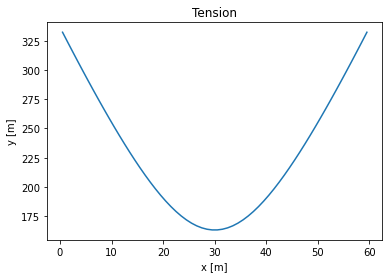

In [11]:
# plot the tension
plt.figure()
X = (np.array([i[0] for i in NodeCoord[0:-1]]) + np.array([i[0] for i in NodeCoord[1:]]))/2
plt.plot(X, TENSION)
plt.title("Tension")
plt.xlabel("x [m]")
plt.ylabel("y [m]")


## Exercise
Determine the mooring configuration of a floating wind turbine attached to two cables of different lengt:

$$L_{\mbox{left}}=100$$
$$L_{\mbox{right}}=150$$

The anchors are positioned at $[-50,-60]$ and $[60,-60]$. The floating wind turbine is at $[0,0]$.

In [ ]:
# Step 1: discretize the domain

In [ ]:
# Step 2: compute initial configuration

In [ ]:
# Step 3: Assemble system and solve